In [2]:
!pip install python-chess
!pip install matplotlib


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# chessRL.py
import random
import chess
import numpy as np
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import matplotlib.pyplot as plt


GPU is available and being used.


In [4]:
def print_custom_board(board):
    """
    Prints the chess board with a fixed-width for each square.
    Each piece is shown with a preceding 'w' for white and 'b' for black,
    centered in a 4-character wide field. Empty squares are shown as '.'.
    The board is printed from rank 8 to 1.
    """
    # Loop over the ranks (8 to 1)
    for rank in range(7, -1, -1):
        # Start the row string with the rank number
        row_str = f"{rank+1}  "
        for file in range(8):
            sq = chess.square(file, rank)
            piece = board.piece_at(sq)
            if piece is None:
                cell_str = "."
            else:
                color = "w" if piece.color == chess.WHITE else "b"
                symbol = piece.symbol().upper()
                cell_str = f"{color}{symbol}"
            # Center the cell_str in a field of width 4
            row_str += f"{cell_str:^4}"
        print(row_str)

    # Print the file letters at the bottom.
    file_str = "    "  # initial padding to align with the board
    for file in range(8):
        file_letter = chr(ord('a') + file)
        file_str += f"{file_letter:^4}"
    print(file_str)
    print()


In [5]:
class ChessRL:
    PIECE_VALUES = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 200,
    }
    action_space = [chess.Move(from_sq, to_sq) for from_sq in chess.SQUARES for to_sq in chess.SQUARES]

    def __init__(self, board, color):
        self.board = board
        self.board_tensor = self.board_to_tensor(board)
        self.color = color

    def board_to_tensor(self, board):
        tensor = torch.zeros(12, 8, 8, dtype=torch.float)
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                if piece.color == chess.WHITE:
                    channel = piece.piece_type - 1
                else:
                    channel = piece.piece_type - 1 + 6
                row = 7 - chess.square_rank(square)
                col = chess.square_file(square)
                tensor[channel, row, col] = 1
        return tensor

    def create_legal_mask(self):
        legal_moves_set = {move.uci() for move in self.board.legal_moves}
        mask = torch.zeros(len(self.action_space), dtype=torch.float)
        for idx, move in enumerate(self.action_space):
            if move.uci() in legal_moves_set:
                mask[idx] = 1.0
        return mask

    def compute_material_score(self, board=None):
        """
        Compute the material difference from the perspective of self.color.

        If self.color == chess.WHITE, returns (White points - Black points).
        If self.color == chess.BLACK, returns (Black points - White points).

        Args:
            board (chess.Board): Optional board to evaluate. If None, uses self.board.

        Returns:
            int: The material difference for the specified color.
        """
        if board is None:
            board = self.board

        white_score = 0
        black_score = 0
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                value = self.PIECE_VALUES.get(piece.piece_type, 0)
                if piece.color == chess.WHITE:
                    white_score += value
                else:
                    black_score += value

        if self.color == chess.WHITE:
            return white_score - black_score
        else:  # self.color == chess.BLACK
            return black_score - white_score

    def update_board(self, board):
        self.board = board
        self.board_tensor = self.board_to_tensor(board)
        current_score = self.compute_material_score(board)
        # Compute the material difference from the previous state.
        self.material_delta = current_score - self.last_material_score
        # Update the last_material_score for the next comparison.
        self.last_material_score = current_score

class ChessPolicyNet(nn.Module, ChessRL):
    def __init__(self, num_actions, board, color, non_capture_penalty=-0.2, epsilon=0.1):
        nn.Module.__init__(self)
        ChessRL.__init__(self, board, color)
        # Define convolutional layers:
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Define fully connected layers:
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_actions)

        self.non_capture_penalty = non_capture_penalty
        self.epsilon = epsilon  # Exploration parameter.

        self.move_history = []
        self.last_material_score = self.compute_material_score(board)

    def forward(self):
        # Use the stored board tensor; assume it’s already updated.
        # Add batch dimension if necessary.
        x = self.board_tensor.to(device).unsqueeze(0)  # Now x has shape (1, 12, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        # Generate legal mask and apply it.
        legal_mask = self.create_legal_mask().to(device)  # Shape: (num_actions,)
        legal_mask = legal_mask.unsqueeze(0).expand_as(logits)
        masked_logits = logits + (legal_mask - 1) * 1e8
        probs = F.softmax(masked_logits, dim=-1)
        return probs

    def choose_move(self):
        # With probability epsilon, choose a random legal move.
        if np.random.rand() < self.epsilon:
            # Obtain legal moves from the board.
            legal_moves = list(self.board.legal_moves)
            # Randomly choose one.
            move = random.choice(legal_moves)

            # Optionally, log that this was a random move.
            # Here, we log a dummy log probability (or you might mark it in the history).
            dummy_log_prob = torch.tensor(0.0, device=self.board_tensor.device)
            points = self.compute_material_score()
            self.move_history.append({
                'state_tensor': self.board_tensor,
                'probs': None,  # Not used for random moves.
                'action_index': None,
                'move': move,
                'log_prob': dummy_log_prob,
                'points': points,
                'random': True  # Mark that this was chosen randomly.
            })
            return move
        else:
            # Otherwise, use the policy network to select a move.
            probs = self.forward()  # Expected shape: (1, num_actions)
            m = D.Categorical(probs)
            action = m.sample()      # Keep this as a tensor.
            action_index = action.item()
            move = self.action_space[action_index]

            # Compute the log probability that remains attached to the computation graph.
            log_prob = m.log_prob(action).to(self.board_tensor.device)
            points = self.compute_material_score()

            self.move_history.append({
                'state_tensor': self.board_tensor,
                'probs': probs,
                'action_index': action_index,
                'move': move,
                'log_prob': log_prob,
                'points': points,
                'random': False  # Mark that this was chosen by the network.
            })

            return move

In [6]:
def compute_entropy(probs):
    """
    Compute the entropy of a probability distribution.
    Args:
        probs (torch.Tensor): Tensor of shape (1, num_actions).
    Returns:
        float: The entropy.
    """
    # Squeeze to remove the batch dimension.
    p = probs.squeeze()
    # Compute entropy: -sum(p * log(p))
    entropy = -torch.sum(p * torch.log(p + 1e-9)).item()
    return entropy

In [7]:
def reinforce_update(policy_net, optimizer, gamma=0.99):
    """
    Perform a REINFORCE update using the move history stored in policy_net.move_history.

    Each move entry should contain:
      - 'log_prob': A tensor containing the log probability (requires grad).
      - 'points': The reward for that move.

    Args:
        policy_net: The policy network instance (e.g., for White or Black).
        optimizer: The optimizer to update policy_net parameters.
        gamma (float): Discount factor.

    Returns:
        float: The loss value.
    """
    # 1. Extract rewards from the move history.
    rewards = [entry['points'] for entry in policy_net.move_history]

    # 2. Compute cumulative discounted rewards (returns).
    returns_list = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns_list.insert(0, R)

    # Create the returns tensor on the same device as the model.
    returns = torch.tensor(returns_list, dtype=torch.float32, device=policy_net.board_tensor.device)
    # Squeeze the returns tensor so that each element is a scalar.
    returns = returns.squeeze()

    # Optionally normalize returns.
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # 3. Compute the REINFORCE loss.
    loss = 0
    for i, entry in enumerate(policy_net.move_history):
        # Squeeze the log probability so that it is a scalar.
        log_prob = entry['log_prob'].squeeze()
        loss += -log_prob * returns[i].squeeze()  # Ensure both are scalars.

    # 4. Backpropagate and update the network.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    print(f"REINFORCE loss: {loss_val:.4f}")

    # Clear the move history for the next batch.
    policy_net.move_history = []
    return loss_val


In [19]:
def play_self_game(
    policy_net_white, 
    policy_net_black, 
    terminal_reward=100, 
    terminal_loss=100,
    per_move_penalty=0,
    move_length_threshold=200,         # Maximum number of moves allowed.
    exceeding_length_penalty=100        # Extra penalty if the game exceeds the threshold.
):
    """
    Play a self-play game between two policy networks, forcefully ending the game
    if it exceeds move_length_threshold, and adjust terminal rewards accordingly.
    
    Returns:
        tuple: (white_move_history, black_move_history, game_length, result)
    """
    # Initialize the board.
    board = chess.Board()
    
    # Play the game.
    while not board.is_game_over():
        # Forcefully end the game if move threshold exceeded.
        if len(policy_net_white.move_history) >= move_length_threshold:
            print("Move threshold exceeded. Forcing game end.")
            break
        
        if board.turn == chess.WHITE:
            policy_net_white.update_board(board)
            previous_material = policy_net_white.compute_material_score()
            move = policy_net_white.choose_move()
            if move not in board.legal_moves:
                continue
            board.push(move)
            policy_net_white.update_board(board)
            current_material = policy_net_white.compute_material_score()
            material_change = current_material - previous_material
            if material_change == 0:
                policy_net_white.move_history[-1]['points'] += policy_net_white.non_capture_penalty
        else:
            policy_net_black.update_board(board)
            previous_material = policy_net_black.compute_material_score()
            move = policy_net_black.choose_move()
            if move not in board.legal_moves:
                continue
            board.push(move)
            policy_net_black.update_board(board)
            current_material = policy_net_black.compute_material_score()
            material_change = current_material - previous_material
            if material_change == 0:
                policy_net_black.move_history[-1]['points'] += policy_net_black.non_capture_penalty

    # Optionally, print the final board.
    # print_custom_board(board)
    print("Game over!")
    result = board.result()
    print("Result:", result)
    
    # Compute the game length.
    game_length = len(policy_net_white.move_history)
    
    # Compute the total penalty based on the game length.
    length_penalty = per_move_penalty * game_length

    # Adjust the terminal rewards based on the game result.
    if result == "1-0":
        terminal_reward_white = terminal_reward
        terminal_reward_black = -terminal_loss
    elif result == "0-1":
        terminal_reward_white = -terminal_loss
        terminal_reward_black = terminal_reward
    else:
        terminal_reward_white = -length_penalty
        terminal_reward_black = -length_penalty

    # If the game exceeded the threshold, apply an extra penalty.
    if game_length >= move_length_threshold:
        terminal_reward_white -= exceeding_length_penalty
        terminal_reward_black -= exceeding_length_penalty

    # Apply these terminal rewards to the last move in each move history.
    if policy_net_white.move_history:
        policy_net_white.move_history[-1]['points'] = policy_net_white.move_history[-1].get('points', 0) + terminal_reward_white
    if policy_net_black.move_history:
        policy_net_black.move_history[-1]['points'] = policy_net_black.move_history[-1].get('points', 0) + terminal_reward_black

    return policy_net_white.move_history, policy_net_black.move_history, game_length, result


In [20]:
def train_chess_policy_networks(
    num_iterations=400,
    games_per_iteration=5,
    epsilon_initial=0.3,
    epsilon_final=0.1,
    lr=0.0004,
    gamma=0.95,
    terminal_reward=1000,
    terminal_loss=100,
    per_move_penalty=1,
    non_capture_penalty=-1,
    move_length_threshold=200,         # New parameter: move threshold
    exceeding_length_penalty=1000,       # New parameter: penalty if game exceeds move_length_threshold
    pretrained_model_path_white="/content/drive/MyDrive/ML_States/policy_net_white2.pth",
    pretrained_model_path_black="/content/drive/MyDrive/ML_States/policy_net_black2.pth",
    save_path_white="/content/drive/MyDrive/ML_States/policy_net_white3.pth",
    save_path_black="/content/drive/MyDrive/ML_States/policy_net_black3.pth",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    """
    Train chess policy networks using self-play and the REINFORCE algorithm.

    Parameters:
        num_iterations (int): Number of training iterations (batches).
        games_per_iteration (int): Number of self-play games per iteration.
        epsilon_initial (float): Starting exploration probability.
        epsilon_final (float): Minimum exploration probability.
        lr (float): Learning rate for the optimizers.
        gamma (float): Discount factor.
        terminal_reward (float): Reward given at the terminal state.
        per_move_penalty (float): Penalty per move taken.
        non_capture_penalty (float): Penalty for non-capturing moves.
        move_length_threshold (int): Maximum number of moves allowed before applying a huge penalty.
        exceeding_length_penalty (float): The extra penalty applied if the game exceeds move_length_threshold.
        pretrained_model_path_white (str or None): Path to the pretrained White model.
        pretrained_model_path_black (str or None): Path to the pretrained Black model.
        save_path_white (str): Path to save the trained White policy network.
        save_path_black (str): Path to save the trained Black policy network.
        device (torch.device): Device on which to run the training.

    Returns:
        dict: A dictionary containing the trained models and training metrics.
    """
    # Instantiate the policy networks for White and Black.
    policy_net_white = ChessPolicyNet(
        num_actions=len(ChessRL.action_space),
        board=chess.Board(),
        color=chess.WHITE,
        non_capture_penalty=non_capture_penalty,
        epsilon=epsilon_initial
    ).to(device)

    policy_net_black = ChessPolicyNet(
        num_actions=len(ChessRL.action_space),
        board=chess.Board(),
        color=chess.BLACK,
        non_capture_penalty=non_capture_penalty,
        epsilon=epsilon_initial
    ).to(device)

    # Load the pretrained models into the networks if provided.
    if pretrained_model_path_white is not None:
        white_state_dict = torch.load(pretrained_model_path_white, map_location=device)
        policy_net_white.load_state_dict(white_state_dict)
    else:
        print("No pretrained White model provided. Training from scratch.")

    if pretrained_model_path_black is not None:
        black_state_dict = torch.load(pretrained_model_path_black, map_location=device)
        policy_net_black.load_state_dict(black_state_dict)
    else:
        print("No pretrained Black model provided. Training from scratch.")

    policy_net_white.train()
    policy_net_black.train()

    # Set up optimizers.
    optimizer_white = torch.optim.Adam(policy_net_white.parameters(), lr=lr)
    optimizer_black = torch.optim.Adam(policy_net_black.parameters(), lr=lr)

    # Initialize lists to store metrics.
    white_avg_points = []
    black_avg_points = []
    white_loss_list = []
    black_loss_list = []
    white_avg_entropy = []
    black_avg_entropy = []
    white_avg_log_probs = []
    black_avg_log_probs = []
    game_length_list = []
    white_win_rates = []
    black_win_rates = []
    draw_rates = []

    # Main training loop.
    for iteration in range(num_iterations):
        # Linearly decay epsilon.
        epsilon = max(epsilon_final, epsilon_initial - (epsilon_initial - epsilon_final) * (iteration / num_iterations))
        policy_net_white.epsilon = epsilon
        policy_net_black.epsilon = epsilon

        print(f"Starting iteration {iteration+1}/{num_iterations} with epsilon = {epsilon:.4f}")

        # Batch data for this iteration.
        batch_white_move_history = []
        batch_black_move_history = []
        game_lengths = []
        results = []  # Expected results: "1-0", "0-1", or "1/2-1/2".

        # Play self-play games.
        for _ in range(games_per_iteration):
            # play_self_game now receives extra parameters for move length penalty.
            white_move_history, black_move_history, game_length, result = play_self_game(
                policy_net_white, policy_net_black,
                per_move_penalty=per_move_penalty,
                terminal_reward=terminal_reward,
                terminal_loss=terminal_loss,
                move_length_threshold=move_length_threshold,
                exceeding_length_penalty=exceeding_length_penalty
            )
            batch_white_move_history.extend(white_move_history)
            batch_black_move_history.extend(black_move_history)
            game_lengths.append(game_length)
            results.append(result)

        # Assign the collected move histories to each network.
        policy_net_white.move_history = batch_white_move_history
        policy_net_black.move_history = batch_black_move_history

        # Perform the REINFORCE update.
        white_loss = reinforce_update(policy_net_white, optimizer_white, gamma=gamma)
        black_loss = reinforce_update(policy_net_black, optimizer_black, gamma=gamma)
        white_loss_list.append(white_loss)
        black_loss_list.append(black_loss)

        # Calculate average points per move.
        white_avg = np.mean([entry['points'] for entry in batch_white_move_history])
        black_avg = np.mean([entry['points'] for entry in batch_black_move_history])
        white_avg_points.append(white_avg)
        black_avg_points.append(black_avg)

        # Compute average entropy and average log probability for chosen moves.
        white_entropies = [compute_entropy(entry['probs']) for entry in batch_white_move_history if entry['probs'] is not None]
        black_entropies = [compute_entropy(entry['probs']) for entry in batch_black_move_history if entry['probs'] is not None]
        white_avg_entropy.append(np.mean(white_entropies) if white_entropies else 0)
        black_avg_entropy.append(np.mean(black_entropies) if black_entropies else 0)

        white_log_probs = [entry['log_prob'].item() for entry in batch_white_move_history if entry['log_prob'] is not None]
        black_log_probs = [entry['log_prob'].item() for entry in batch_black_move_history if entry['log_prob'] is not None]
        white_avg_log_probs.append(np.mean(white_log_probs) if white_log_probs else 0)
        black_avg_log_probs.append(np.mean(black_log_probs) if black_log_probs else 0)

        # Average game length.
        avg_game_length = np.mean(game_lengths)
        game_length_list.append(avg_game_length)

        # Compute win, loss, and draw rates.
        white_wins = sum(1 for r in results if r == "1-0")
        draws = sum(1 for r in results if r == "1/2-1/2")
        white_losses = sum(1 for r in results if r == "0-1")
        total_games = len(results)
        win_rate_white = white_wins / total_games
        draw_rate = draws / total_games
        win_rate_black = white_losses / total_games  # Black wins when white loses.
        white_win_rates.append(win_rate_white)
        black_win_rates.append(win_rate_black)
        draw_rates.append(draw_rate)

        print(f"Iteration {iteration+1} complete.")
        print(f"  Avg Game Length: {avg_game_length:.2f}")
        print(f"  White Avg Points: {white_avg:.2f}, Black Avg Points: {black_avg:.2f}")
        print(f"  White Win Rate: {win_rate_white:.2f}, Black Win Rate: {win_rate_black:.2f}, Draw Rate: {draw_rate:.2f}\n")

    # Save the trained models.
    torch.save(policy_net_white.state_dict(), save_path_white)
    torch.save(policy_net_black.state_dict(), save_path_black)
    print("Models saved.")

    # Package metrics and models in a dictionary for return.
    metrics = {
        "policy_net_white": policy_net_white,
        "policy_net_black": policy_net_black,
        "white_loss_list": white_loss_list,
        "black_loss_list": black_loss_list,
        "white_avg_points": white_avg_points,
        "black_avg_points": black_avg_points,
        "white_avg_entropy": white_avg_entropy,
        "black_avg_entropy": black_avg_entropy,
        "white_avg_log_probs": white_avg_log_probs,
        "black_avg_log_probs": black_avg_log_probs,
        "game_length_list": game_length_list,
        "white_win_rates": white_win_rates,
        "black_win_rates": black_win_rates,
        "draw_rates": draw_rates
    }

    return metrics


In [10]:

def bin_data(data, num_bins):
    """
    Splits a list/array of data into a specified number of bins,
    and computes the mean and standard deviation in each bin.
    
    Parameters:
        data (list or np.array): The data to be binned.
        num_bins (int): Number of bins to aggregate the data into.
    
    Returns:
        bin_centers (np.array): The x-axis positions (bin centers or representative iteration numbers).
        bin_means (np.array): The mean value in each bin.
        bin_stds (np.array): The standard deviation in each bin.
    """
    data = np.array(data)
    n = len(data)
    bin_size = int(np.ceil(n / num_bins))
    bin_means = []
    bin_stds = []
    bin_centers = []
    for i in range(0, n, bin_size):
        bin_slice = data[i:i+bin_size]
        bin_means.append(np.mean(bin_slice))
        bin_stds.append(np.std(bin_slice))
        # Use the midpoint of the bin as the representative iteration number:
        bin_centers.append(i + len(bin_slice) / 2.0)
    return np.array(bin_centers), np.array(bin_means), np.array(bin_stds)

def plot_training_metrics_binned(metrics, num_bins=20):
    """
    Plot training metrics by binning the iteration data to provide a clearer view of trends.
    
    Parameters:
        metrics (dict): Dictionary containing the following keys:
            - white_loss_list
            - black_loss_list
            - white_avg_points
            - black_avg_points
            - white_avg_entropy
            - black_avg_entropy
            - white_avg_log_probs
            - black_avg_log_probs
            - game_length_list
            - white_win_rates
            - black_win_rates
            - draw_rates
        num_bins (int): Number of bins into which the iterations will be grouped.
    """
    # Set up a 2x3 grid for plotting.
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Binned REINFORCE Loss for White and Black.
    iterations, white_loss_means, white_loss_stds = bin_data(metrics['white_loss_list'], num_bins)
    _, black_loss_means, black_loss_stds = bin_data(metrics['black_loss_list'], num_bins)
    axs[0, 0].errorbar(iterations, white_loss_means, yerr=white_loss_stds, marker='o', color='blue', label='White Loss')
    axs[0, 0].errorbar(iterations, black_loss_means, yerr=black_loss_stds, marker='o', color='red', label='Black Loss')
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_title("Binned REINFORCE Loss per Iteration")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # 2. Binned Average Points per Iteration.
    iterations, white_avg_points_means, white_avg_points_stds = bin_data(metrics['white_avg_points'], num_bins)
    _, black_avg_points_means, black_avg_points_stds = bin_data(metrics['black_avg_points'], num_bins)
    axs[0, 1].errorbar(iterations, white_avg_points_means, yerr=white_avg_points_stds, marker='o', color='blue', label='White Avg Points')
    axs[0, 1].errorbar(iterations, black_avg_points_means, yerr=black_avg_points_stds, marker='o', color='red', label='Black Avg Points')
    axs[0, 1].set_xlabel("Iteration")
    axs[0, 1].set_ylabel("Avg Points")
    axs[0, 1].set_title("Binned Average Points per Iteration")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 3. Binned Average Entropy per Iteration.
    iterations, white_avg_entropy_means, white_avg_entropy_stds = bin_data(metrics['white_avg_entropy'], num_bins)
    _, black_avg_entropy_means, black_avg_entropy_stds = bin_data(metrics['black_avg_entropy'], num_bins)
    axs[0, 2].errorbar(iterations, white_avg_entropy_means, yerr=white_avg_entropy_stds, marker='o', color='blue', label='White Avg Entropy')
    axs[0, 2].errorbar(iterations, black_avg_entropy_means, yerr=black_avg_entropy_stds, marker='o', color='red', label='Black Avg Entropy')
    axs[0, 2].set_xlabel("Iteration")
    axs[0, 2].set_ylabel("Avg Entropy")
    axs[0, 2].set_title("Binned Average Entropy per Iteration")
    axs[0, 2].legend()
    axs[0, 2].grid(True)

    # 4. Binned Average Log Probabilities per Iteration.
    iterations, white_avg_log_probs_means, white_avg_log_probs_stds = bin_data(metrics['white_avg_log_probs'], num_bins)
    _, black_avg_log_probs_means, black_avg_log_probs_stds = bin_data(metrics['black_avg_log_probs'], num_bins)
    axs[1, 0].errorbar(iterations, white_avg_log_probs_means, yerr=white_avg_log_probs_stds, marker='o', color='blue', label='White Avg Log Prob')
    axs[1, 0].errorbar(iterations, black_avg_log_probs_means, yerr=black_avg_log_probs_stds, marker='o', color='red', label='Black Avg Log Prob')
    axs[1, 0].set_xlabel("Iteration")
    axs[1, 0].set_ylabel("Avg Log Prob")
    axs[1, 0].set_title("Binned Average Log Probability per Iteration")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # 5. Binned Average Game Length per Iteration.
    iterations, game_length_means, game_length_stds = bin_data(metrics['game_length_list'], num_bins)
    axs[1, 1].errorbar(iterations, game_length_means, yerr=game_length_stds, marker='o', color='purple')
    axs[1, 1].set_xlabel("Iteration")
    axs[1, 1].set_ylabel("Moves")
    axs[1, 1].set_title("Binned Average Game Length per Iteration")
    axs[1, 1].grid(True)

    # 6. Binned Win/Loss/Draw Rates per Iteration.
    iterations, white_win_rates_means, white_win_rates_stds = bin_data(metrics['white_win_rates'], num_bins)
    _, black_win_rates_means, black_win_rates_stds = bin_data(metrics['black_win_rates'], num_bins)
    _, draw_rates_means, draw_rates_stds = bin_data(metrics['draw_rates'], num_bins)
    axs[1, 2].errorbar(iterations, white_win_rates_means, yerr=white_win_rates_stds, marker='o', color='blue', label='White Win Rate')
    axs[1, 2].errorbar(iterations, black_win_rates_means, yerr=black_win_rates_stds, marker='o', color='red', label='Black Win Rate')
    axs[1, 2].errorbar(iterations, draw_rates_means, yerr=draw_rates_stds, marker='o', color='green', label='Draw Rate')
    axs[1, 2].set_xlabel("Iteration")
    axs[1, 2].set_ylabel("Rate")
    axs[1, 2].set_title("Binned Win/Loss/Draw Rates per Iteration")
    axs[1, 2].legend()
    axs[1, 2].grid(True)

    plt.tight_layout()
    plt.show()


In [23]:
metrics = train_chess_policy_networks(
    num_iterations=2000,
    games_per_iteration=5,
    epsilon_initial=0.1,
    epsilon_final=0.0,
    lr=0.00001,
    gamma=0.95,
    terminal_reward=1000,
    terminal_loss=100,
    per_move_penalty=0,
    non_capture_penalty=-0.15,
    move_length_threshold=120,
    exceeding_length_penalty=0,
    pretrained_model_path_white="policy_net_white1.pth",
    pretrained_model_path_black="policy_net_black1.pth",
    save_path_white="policy_net_white1.pth",
    save_path_black="policy_net_black1.pth",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

C:\Users\Lukas\AppData\Local\Temp\ipykernel_580\849216722.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  white_state_dict = torch.load(pretrained_model_path_white, map

Starting iteration 1/2000 with epsilon = 0.1000
Move threshold exceeded. Forcing game end.
Game over!
Result: *
Move threshold exceeded. Forcing game end.
Game over!
Result: *
Move threshold exceeded. Forcing game end.
Game over!
Result: *
Move threshold exceeded. Forcing game end.
Game over!
Result: *
Move threshold exceeded. Forcing game end.
Game over!
Result: *
REINFORCE loss: -29.7752
REINFORCE loss: 19.9873
Iteration 1 complete.
  Avg Game Length: 120.00
  White Avg Points: -9.36, Black Avg Points: 8.87
  White Win Rate: 0.00, Black Win Rate: 0.00, Draw Rate: 0.00

Starting iteration 2/2000 with epsilon = 0.1000
Move threshold exceeded. Forcing game end.
Game over!
Result: *
Move threshold exceeded. Forcing game end.
Game over!
Result: *
Move threshold exceeded. Forcing game end.
Game over!
Result: *
Move threshold exceeded. Forcing game end.
Game over!
Result: *
Move threshold exceeded. Forcing game end.
Game over!
Result: *
REINFORCE loss: 221.0975
REINFORCE loss: -135.3771
Ite

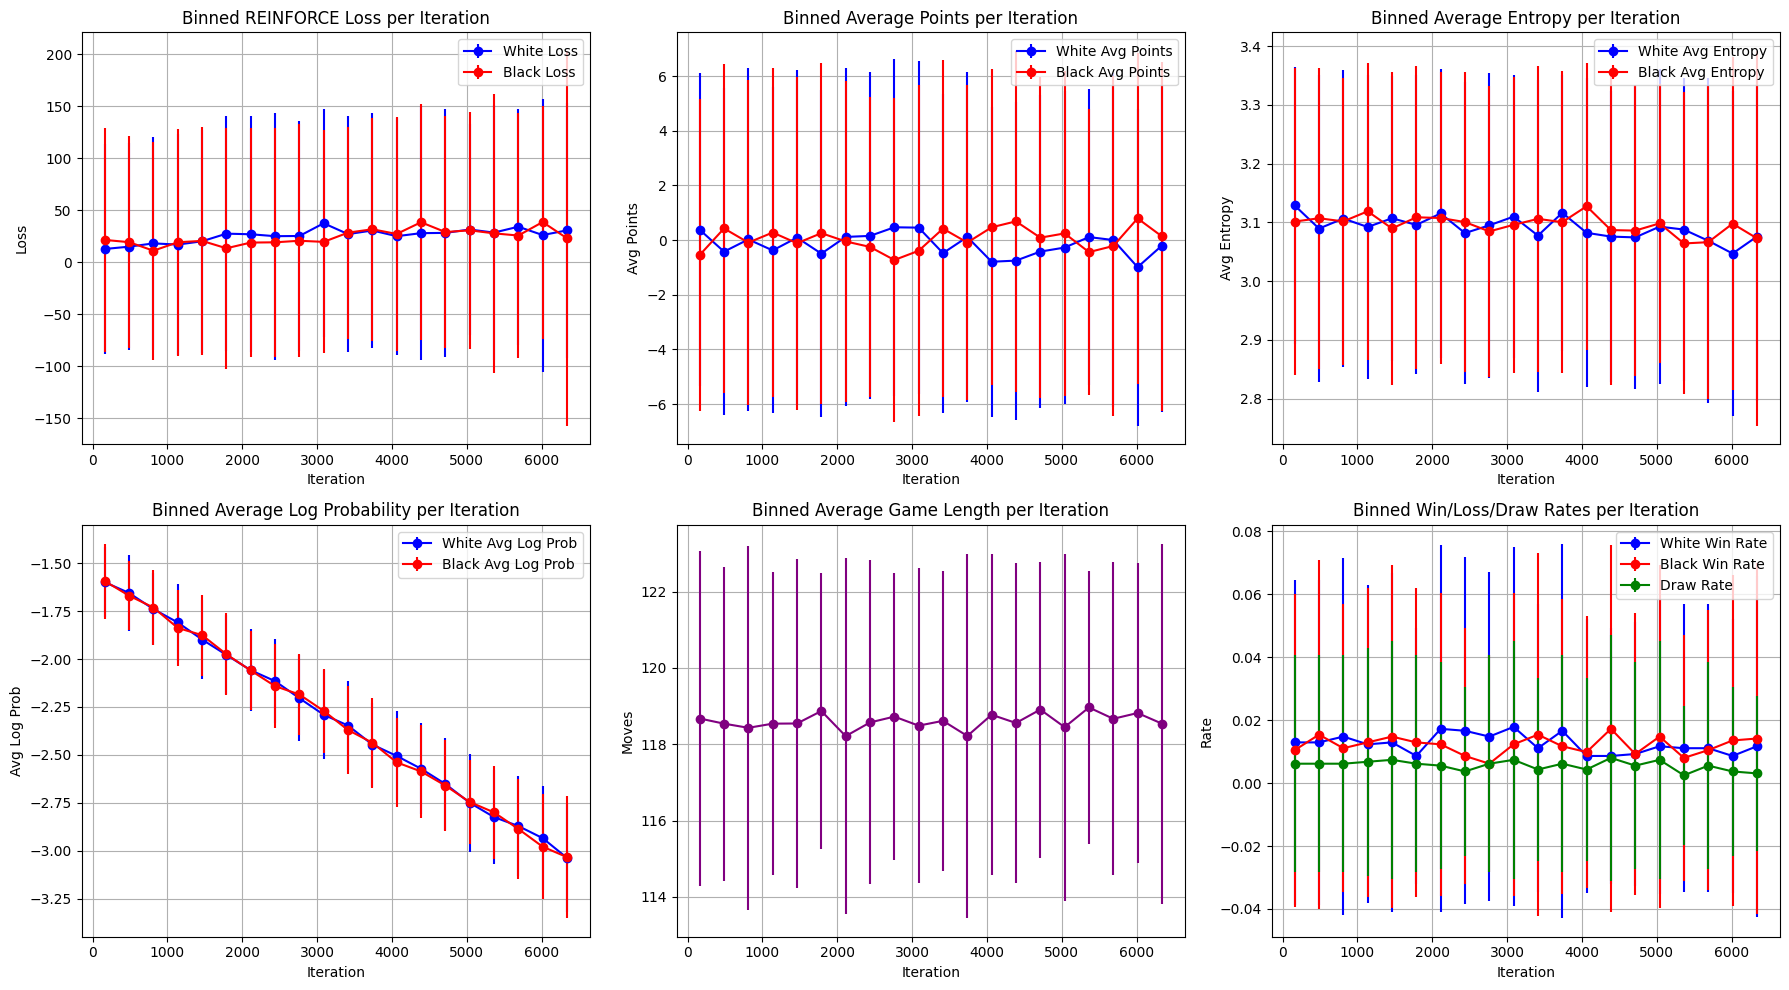

In [22]:
plot_training_metrics_binned(metrics)